# <span style="color:#F72585"><center>Métodos de agrupación HDBSCAN</center></span>

## <span style="color:#4361EE">Introducción</span>

Los algoritmos de agrupamiento de los datos más conocidos, no siempre generan resultados correctos en contextos de alta dimensionalidad o bajo la presencia de datos atípicos los cuales pueden mostrar una alteración en la forma natural en la cual los datos se agrupan. El agrupamiento espacial basado en densidad de aplicaciones con ruido jerárquico o HDBSCAN por sus siglas en inglés, es un algoritmo de agrupamiento de datos basado en densidades, dado que construye los grupos de datos estimando las distribuciones de densidad de cada uno de ellos, comenzando por los nodos correspondientes. 

## <span style="color:#4361EE">Nota Historica</span>

Para 1990 Kaufman & Rousseeuw dan una definición lo bastante clara de los dos tipos de algoritmos de agrupamiento, la familia de partición y la familia de jerarquía. Los algoritmos de partición se basan en construir una partición en $k$ grupos o clusters del conjunto de datos observados, en donde el valor de $k$ corresponde a un valor de entrada, lo cual implica que se debe tener información previa sobre el comportamiento de estos grupos, y de la cual no se dispone para la mayoría de los casos. 

Primeramente los algoritmos de partición arrancaban con una partición inicial de los datos y emplearon una estrategia iterativa de control con el fin de optimizar una función objetivo. Consecuentemente la estrategia para construir los cluster cambió a la metodología de 2 pasos. El primer paso consiste en hallar un valor representativo de $k$  que minimice una función objetivo dada. El segundo paso consiste en asignar cada dato a uno de los cluster junto con los datos representativos más cercanos a este dada una métrica. El segundo paso implica que una partición es equivalente a un diagrama de voronoi y cada cluster estaría contenido en una de las celdas del diagrama.   


<figure>
<center>
<img src="Images/Voronoi.svg", width = 300, height = 200 align="center" /> 
</center>   
</figure>
Fuente: <a href="https://es.wikipedia.org/wiki/Pol%C3%ADgonos_de_Thiessen#/media/Archivo:Euclidean_Voronoi_diagram.svg">, Public domain, via Wikimedia Commons

Ng & Han en 1994 exploran los algoritmos particionados para el descubrimiento de conocimiento en bases de datos en datos espaciales, donde proponen un algoritmo llamado CLARANS (Clustering Large Applications based on RANdomized Search)  el cual es una mejora del método de k-medoides. También discutieron métodos para determinar lo que ellos llamaron el número “natural” $k_{nat}$ de clusters en un conjunto de datos. Ellos propusieron utilizar CLARANS en  cada uno de los posibles valores de $k$, para luego calcular el coeficiente de silhouette y finalmente elegir como número “natural” al conjunto de clusters que maximiza el coeficiente de silhouette. Por último Ester, Kriegel &Xu en 1995 proponen mejoras a este método basándose en estrategias enfocadas en resaltar partes importantes del conjunto de datos.

Por otra parte, los algoritmos basados en jerarquías proponen una descomposición jerárquica del conjunto de datos. Esta descomposición jerárquica es representada por medio de un dendrograma, un árbol que divide iterativamente el conjunto de datos en subconjuntos más pequeños hasta que cada subconjunto está compuesto de una sola observación.  Este árbol puede ser construido de dos formas distintas, de la raíz hasta las hojas (enfoque divisivo) o de las hojas hasta la raíz (enfoque aglomerativo). Para 1994 en el área de procesamiento de señales se presentó el algoritmo jerárquico Ejcluster (Garcfa, Fdez-Valdivia, Cortijo & Molina 1994) que deriva automáticamente una condición de terminación. Su idea clave es que dos puntos pertenecen al mismo cluster si puedes caminar desde el primer punto hasta el segundo con un paso "lo suficientemente pequeño". Ejcluster sigue el enfoque divisivo. No requiere ninguna entrada de conocimiento del dominio como sí ocurre con los algoritmos de partición. 

Jain (1988) explora un enfoque basado en la densidad para identificar clusters en conjuntos de datos k-dimensionales. El conjunto de datos se divide en varias celdas que no se superponen y se construyen histogramas. Las celdas con conteos de puntos de frecuencia relativamente alta son los centros potenciales de los grupos y los límites entre los grupos caen en los "valles" del histograma. Este método tiene la capacidad de identificar grupos de cualquier forma. 


El algoritmo HDBSCAN, desarrollado por Campello, Moulavi, and Sander. en el 2013 como una mejora a su predeseror, el DBSCAN, el cual fue propuesto por Martin Ester, Hans-Peter Kriegel, Jörg Sander y Xiaowei Xu en 1996

## <span style="color:#4361EE">Fundamento Matematico</span>

### <span style="color:#4CC9F0">Revision del DBSCAN </span>

Sea $\textbf{X} = \left\{\textbf{x}_1, \dots, \text{x}_n \right\}$ un conjunto de $n$ observaciones tales que $\textbf{x}_i \in \mathbb{R}^m$ para $i = 1, \dots, n$ y sea $D$ una matriz de orden $n \times n$ que tiene todas las distancias entre puntos $d\left(\textbf{x}_p, \textbf{x}_q\right)$ con $\textbf{x}_p, \textbf{x}_q \in \textbf{X}$, para una métrica de distancia dada $d\left(\cdot,\cdot\right)$. 

$\textbf{Definición 1.}$ (Punto Nucleo): Un punto $\textbf{x}_i$ es llamado un punto nucleo, si para una distancia dada $\varepsilon$ hay almenos $m_{pts}$ puntos a su alrededor, i.e., si $\mid\text{N}_{\varepsilon}\left(\textbf{x}_i\right)\mid \geq m_{pts}$, donde $\text{N}_{\varepsilon}\left(\textbf{x}_i\right) = \left\{\textbf{x} \in \textbf{X} \mid d\left(\textbf{x},\textbf{x}_i\right) \leq \varepsilon\right\}$ y $\mid\cdot\mid$ denota la cardinalidad del conjunto. Un punto sera llamado ruido si este no es un punto nucleo.

$\textbf{Definición 2.}$ ($\varepsilon$-Alcanzable): Se dirá que dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ son $\varepsilon$-alcanzables con respecto a $\varepsilon$ y $m_{pts}$ si $\textbf{x}_p \in \text{N}_{\varepsilon}\left(\textbf{x}_q\right)$ y $\textbf{x}_q \in \text{N}_{\varepsilon}\left(\textbf{x}_p\right)$.

$\textbf{Definición 3.}$ (Conectados por Densidad): Dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ estan Conectados por densidad con respecto a $\varepsilon$ y $m_{pts}$ si son directa o transitivamente $\varepsilon$-alcanzables.

$\textbf{Definición 4.}$ (Cluster): Un cluster $\textbf{C}$ con respecto a $\varepsilon$ y $m_{pts}$ es un subconjunto maximal no vacío de $\textbf{X}$ tal que para cada par de puntos in $\textbf{C}$ estos están conectados por densidad 

Basado en las cuatro definiciones anteriores se puede construir la nueva versión DBSCAN* la cual es similar al DBSCAN. Recuerde que los clusters son construidos en base a las conecciones de los componentes de un gráfico particular en el cual los puntos de $\textbf{X}$ son los vértices, y cada par de puntos son adyacentes entre si, si y sólo si los dos puntos seleccionados son $\varepsilon$-alcanzables con respecto a los valores escogidos para $\varepsilon $ y $m_{pts}$

Note que en la definición original del DBSCAN también se incluye la definición de *punto frontera* la cual dice que: Un punto es frontera si este no es un punto núcleo pero se encuentra dentro de una $\varepsilon$-vecindad de un punto núcleo. 


### <span style="color:#4CC9F0">Hierarchical DBSCAN* - HDBSCAN </span>

En esta sección se introducirá la construcción del método de agrupamiento jerárquico llamado HDBSCAN, este método está basado principalmente en su hermano mayor el DBSCAN, teniendo en general varias diferencial las cuales hacen superior al HDBSCAN. A continuación se introducen unas nuevas definiciones necesarias para la construcción de este nuevo algoritmo.

$\textbf{Definicion 5.}$ (Distancia Núcleo): La distancia núcleo de un punto $\textbf{x}_p \in \textbf{X}$ con respecto a $m_{pts}$, se dira que $d_{core}\left(\textbf{x}_p\right)$ es la distancia de $\textbf{x}_p$ con respecto a sus $m_{pts}$-vecinos más cercanos incluyendo al mismo punto $\textbf{x}_p$ 

$\textbf{Definición 6.}$ (Punto nucleo-$\varepsilon$): Un punto $\textbf{x}_p\in \textbf{X}$ es llamado Punto nucleo-$\varepsilon$ para cada valor de $\varepsilon $ que sea mayor o igual a la distancia núcleo del punto $\textbf{x}_p$ con respecto a $m_{pts}$, i.e., $d_{core}\left(\textbf{x}_p\right) \leq \varepsilon$

$\textbf{Definición 7.}$ (Distancia de alcance mutuo): La distancia de alcance mutuo entre dos puntos $\textbf{x}_p$ y $\textbf{x}_q$ en $\textbf{X}$ con respecto a $m_{pts}$ está definida de la siguiente forma:  $$d_{mreach}\left(\textbf{x}_p, \textbf{x}_q\right) = \text{Max}\left\{ d_{core}\left(\textbf{x}_p\right), d_{core}\left(\textbf{x}_q\right),d\left(\textbf{x}_p, \textbf{x}_q\right)\right\}$$

$\textbf{Definición 8.}$ (Gráfico de Alcance Mutuo): Este es un gráfico completo, al cual llamaremos $G_{m_{pts}}$, en el cual los puntos de $\textbf{X}$ son vértices y el peso de cada borde es la distancia de alcance mutuo entre cada respectivo par de puntos, todo esto nuevamente con respecto a $m_{pts}$. 




### <span style="color:#4CC9F0">Construccion de los Clusters </span>

Sin pérdida de generalidad, primero se supondrá que los datos provienen de una población con distribución continua, la cual se supondrá que cuenta con más de una moda con diferentes frecuencias relativas, los clusters de densidad-contorno de la función de densidad dada $f\left(x\right)$ estarán definidos como los subconjuntos que se encuentran con la mayor conexión posible definidos como $\left\{x \mid f\left(x\right) \geq \lambda\right\}$
donde $\lambda$ corresponde a un nivel de densidad dado. La mayoría de algoritmos de agrupación son una extensión de este concepto, la gran diferencia está en que este método estima la función de densidad y los subconjuntos máximo conectados, e.g., el método DBSCAN* estima los grupos de contorno de densidad para un nivel de densidad $\lambda = 1/\varepsilon$ y el valor de $m_{pts}$ es estimado mediante la metodología $K-NN$.   

La nueva alternativa HDBSCAN lo que consigue es calcular todas las posibles soluciones del DBSCAN* con respecto a un valor de $m_{pts}$ dado y todos los posibles valores de $\lambda = 1/\varepsilon$ en el intervalo $[0, \infty)$.

Con el fin de darle una formalidad teórica a este concepto, se adaptara la noción de exceso de masa propuesta por Muller, D.W., Sawitzki, G. Imagine que se aumenta el nivel de densidad $\lambda$ y suponga que un grupo de contorno de densidad $\textbf{C}_i$ aparece en el nivel $\lambda_{min}\left(\textbf{C}_i\right)$. El exceso de masa de $\textbf{C}_i$ está definido en la ecuación (1) y lo podemos ver ilustrado en la figura 1, donde las áreas sombreadas más oscuras representan el exceso de masa de los tres clusters, $\textbf{C}_3, \textbf{C}_4$ y $\textbf{C}_5$. el exceso de masa de $\textbf{C}_2$ (No resaltado en la figura) engloba las de sus descendientes $\textbf{C}_4$ y $\textbf{C}_5$.


\begin{align}
    	E\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(f\left(x\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
    \end{align}

<figure>
<center>
<img src="Images/density.png", width = 600, height = 400 align="center" /> 
</center>   
</figure>

Fuente: <a href="https://doi.org/10.1007/978-3-642-37456-2_14">, Springer

**Figura 1** Ilustracion de la funcion de densidad, clusters y exceso de masa.

<figure>
<center>
<img src="Images/tree.png", width = 600, height = 400 align="center" /> 
</center>   
</figure>

Fuente: <a href="https://doi.org/10.1007/978-3-642-37456-2_14">, Springer

**Figura 2** Ilustracion de la seleccion optima de clusters para un árbol de cluster dado.

El exceso de masa exhibe un comportamiento monótono a lo largo de cualquier rama del árbol de conglomerados jerárquicos. Como consecuencia, esta medida no se puede utilizar para comparar las estabilidades de los clústeres anidados, como $\textbf{C}_2$ contra $\textbf{C}_4$ y $\textbf{C}_5$. Con el fin de realizar esta comparacion, se introduce la nocion de *exceso de masa relativo* para un cluster $\textbf{C}_i$ el cual aparece al nivel de densidad $\lambda_{min}\left(\textbf{C}_i\right)$ como:

\begin{align}
    	E_R\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
\end{align}

Donde $\lambda_{max}\left(x,\textbf{C}_i\right)= \text{min}\left\{f\left(x\right), \lambda_{max}\left(\textbf{C}_i\right)\right\}$ y $\lambda_{max}\left(\textbf{C}_i\right)$ es el nivel de densidad para el cual $\textbf{C}_i$ se divide o desaparece, e.g., para el cluster $\textbf{C}_2$ en la Figura 1 se puede deducir que $\lambda_{max}\left(\textbf{C}_2\right)=\lambda_{min}\left(\textbf{C}_4\right)=\lambda_{min}\left(\textbf{C}_5\right)$. Así se puede apreciar que el exceso de masa realitvo esta representado por el área sombreada más clara en la Figura 1.

Para el caso de la vida real cuando se tiene un conjunto de datos $\textbf{X}$ limitado, se propone adaptar la Ecuacion 2 con el fin de obtener una forma empirica de medir la estabilidad del cluster $\textbf{C}_i$. Teniendo asi el siguiente resultado:

\begin{align}
    	S\left(\textbf{C}_i\right) &= \sum_{x_j \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right) \\
		&= \sum_{x_j \in \textbf{C}_i} \left(\frac{1}{\varepsilon_{min}\left(\textbf{x}_j, \textbf{C}_i\right)} - \frac{1}{\varepsilon_{max}\left(\textbf{C}_i\right)}\right)
\end{align}

Donde $\lambda_{min}\left(\textbf(C)_i\right)$ es el nivel de densidad minima para el cual $\textbf{C}_i$ existe, $\lambda_{max}\left(\textbf{x}_j,\textbf{C}_i\right)$ es el nivel de densidad a partir del cual el objeto $\textbf{x}_j$ deja de pertenecer al grupo $\textbf{C}_i$, y $\varepsilon_{max}\left(\textbf{C}_i\right)$ y $\varepsilon_{min}\left(\textbf{x}_j,\textbf{C}_i\right)$ son los valores correspondientes al valor de umbral $\varepsilon$ para cada caso.


## <span style="color:#4361EE">Implementacion</span> 

Con el fin de mostrar la correcta implementación del algoritmo HDBSCAN  primeramente se mostrará un ejemplo con un conjunto de datos bastante interesante. Como segundo caso se mostrará un ejemplo completo en donde veremos como llevar a cabo cada uno de los pasos necesarios para una correcta implementación del HDBSCAN.  

In [3]:
import numpy as np  # para operaciones de arreglos
import pandas as pd
import matplotlib.pyplot as plt # para gráficos
import seaborn as sns # gráficos estadísticos
import sklearn.cluster as cluster  # clusters para comparaciones
import hdbscan # para el cluster hdbscan
import time  # para comparación de tiempos
from sklearn.datasets import make_moons  # simular datos
from sklearn.datasets import make_blobs
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture # mezclas gaussianas

sns.set_theme()
sns.set_color_codes()
plot_kwds = {'alpha' : 0.35, 's' : 40, 'linewidths':0}

Primero importamos los datos, estos corresponde a un conjunto de datos bastante interesantes por su distribución, los cuales fueron creados a partir de una simulación y podrá encontrar en este repositorio en el siguiente [link](https://github.com/Daveztat/HDBSCAN/blob/main/Data/ds3.csv). 

In [4]:
data = pd.read_csv("./Data/ds3.csv")
data = data.iloc[:,1:].values # Se elimina la primera columna que contiene un identificador

Después de importar los datos generamos una gráfica con el fin de visualizarlos y entender un poco más de su comportamiento.

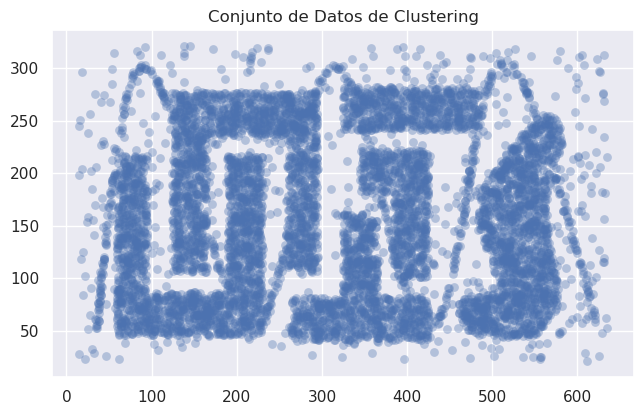

In [5]:
plt.subplots(figsize =(7.5, 4.5))
plt.title('Conjunto de Datos de Clustering')
plt.scatter(data[:,0],data[:,1],**plot_kwds)

In [6]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.title('Clusters encontrados por {}'.format(str(algorithm.__name__)), fontsize=17)
    plt.text(-0.5, 0.68, 'Clustering tomo {:.2f} s'.format(end_time - start_time), fontsize=10)

A continuación por medio de gráficas vamos a  mostrar el desempeño de algunos de los algoritmos de clustering más implementados vs el HDBSCAN

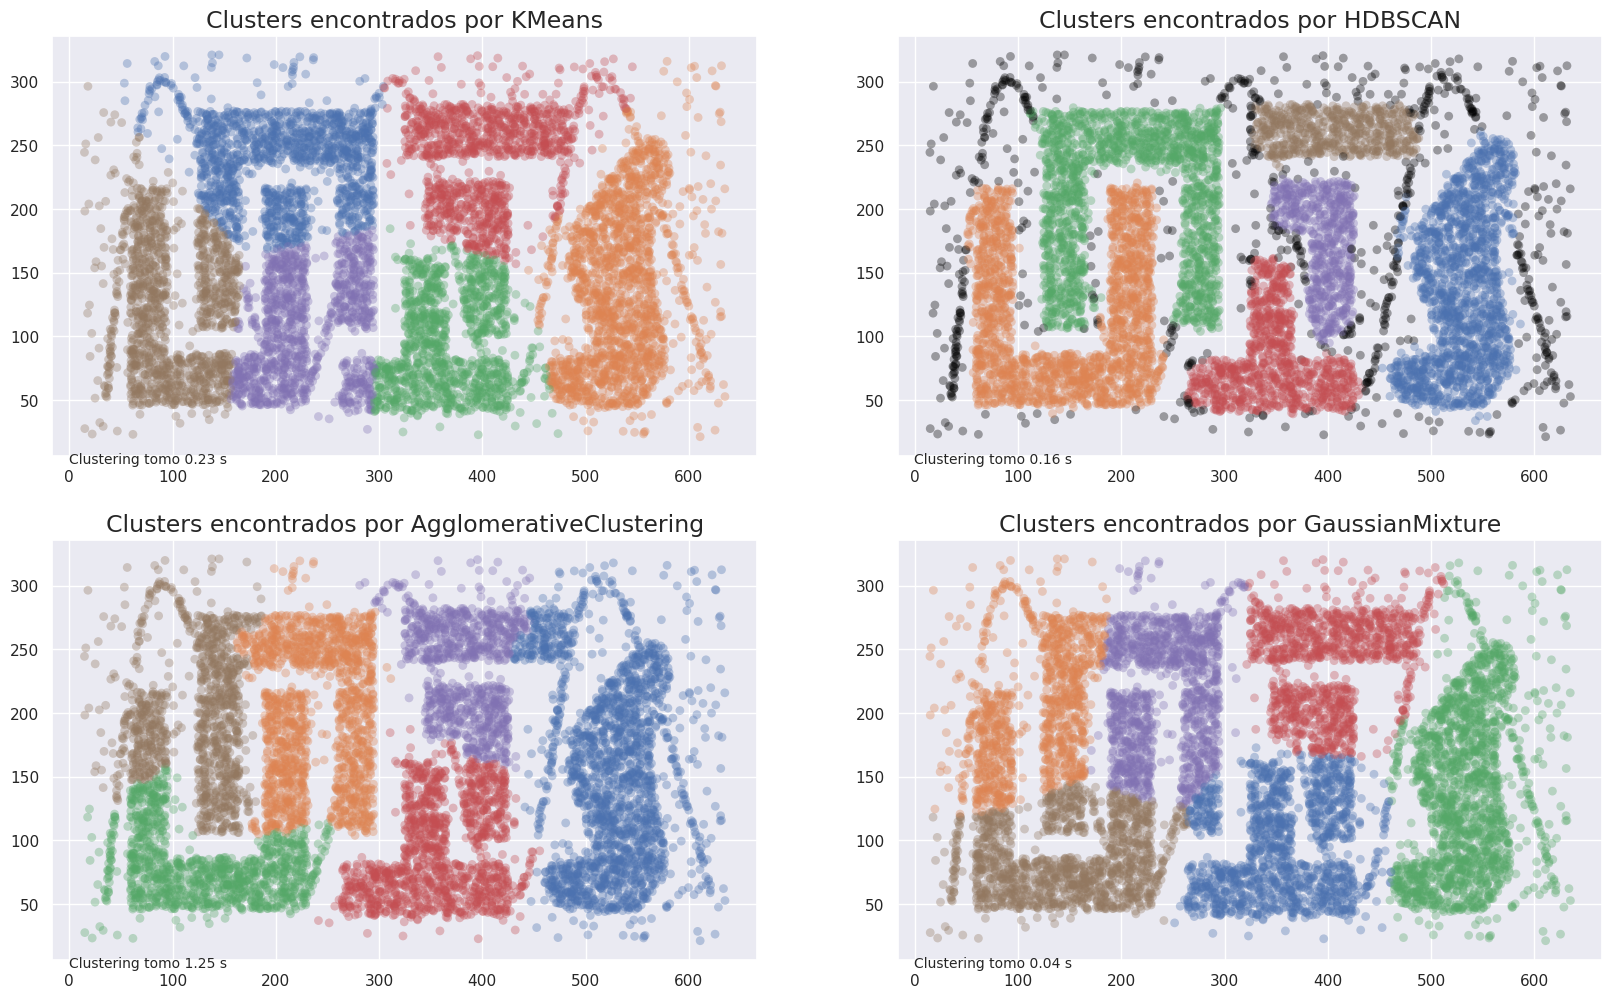

In [7]:
plt.figure(figsize = (20,12))
plt.subplot(221)
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})
plt.subplot(222)
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':25})
plt.subplot(223)
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
plt.subplot(224)
plot_clusters(data, GaussianMixture, "",{"n_components":6})

Como se pudo apreciar en la gráfica anterior el desempeño del HDBSCAN es superior a los demás métodos con los cuales este se comparó. Ahora procederemos a mostrar la completa implementación del HDBSCAN con un ejemplo juguete.

### <span style="color:#4CC9F0">Consideremos un ejemplo juguete para ver la implementación del HDBSCAN</span>

Este ejemplo de juguete es una simulación de datos con una distribución bastante interesante.  

In [8]:
import sklearn.datasets as ds
datak, labels = ds.make_circles(n_samples=250, 
                               shuffle=True, 
                               noise=0.03, 
                               random_state=123,
                               factor = 0.5)

centers = [ [4, 1], [4.5, 3]]
data2, labels2 = make_blobs(n_samples=200, 
                            cluster_std = 0.2,
                            centers=centers,
                            random_state=123)


#for i in range(len(centers)-1, -1, -1):
#    labels2[labels2==0+i] = i+2
labels2 += +2
    
labels = np.concatenate([labels, labels2])
datak = datak * [1.2, 1.8] + [1, 4.1]
datak = np.concatenate([datak, data2], axis=0)

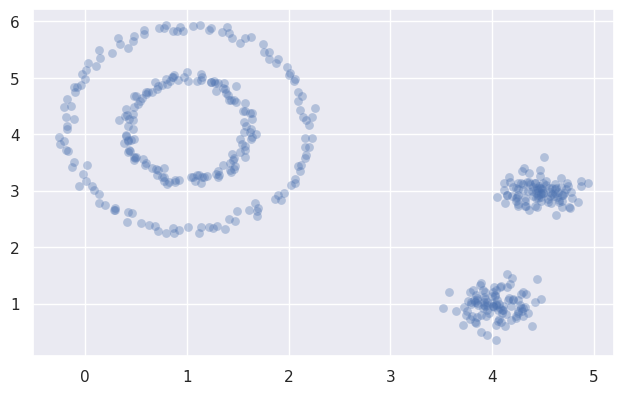

In [9]:
plt.figure(figsize = (7.5, 4.5))
plt.scatter(datak.T[0], datak.T[1],**plot_kwds)

A simple vista podemos observar que hay 4 grupos, pues vemos que hay 4 estructuras que guardan cierta relación en cuanto a su densidad.

Para realizar la agrupación por medio de HDBSCAN solamente se debe pasar el número mínimo de puntos que debe tener un cluster.

En este ejemplo, consideraremos que un cluster puede tener un tamaño mínimo de 5 puntos, se usará la métrica euclidiana, y se deja como True el argumento gen_min_span_tree, esto para poder generar el árbol jerárquico.

In [10]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, metric = "euclidean") # instanciamos
clusterer.fit(datak)  # ajustamos los datos

HDBSCAN(gen_min_span_tree=True)

<AxesSubplot:>

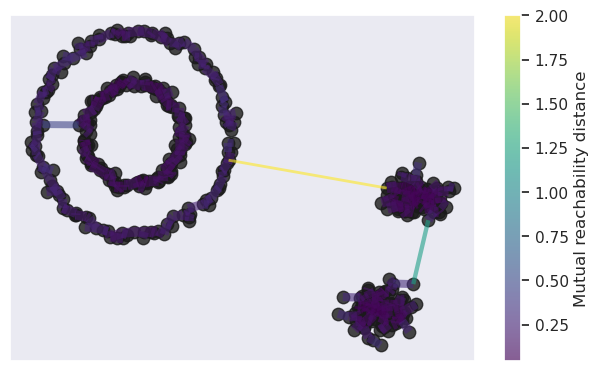

In [11]:
plt.subplots(figsize =(7.5, 4.5))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

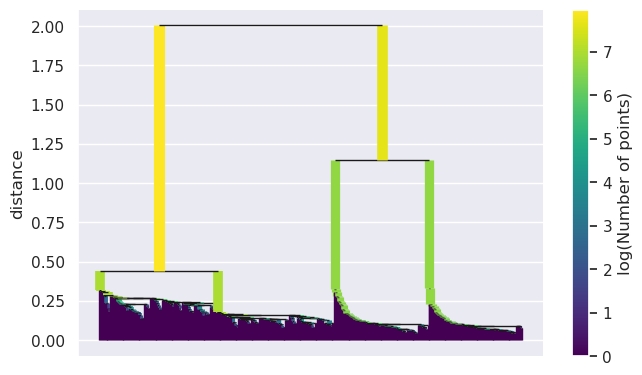

In [12]:
plt.subplots(figsize =(7.5, 4.5))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

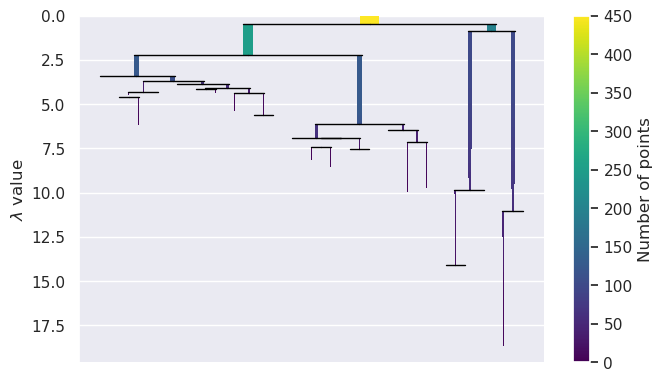

In [13]:
plt.subplots(figsize =(7.5, 4.5))
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

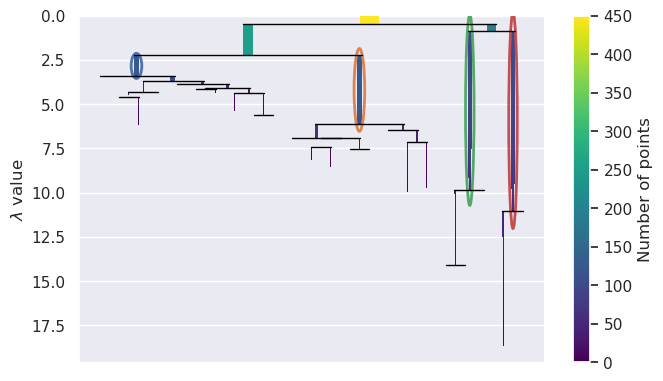

In [14]:
plt.subplots(figsize =(7.5, 4.5))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

HDBSCAN detecta 4 grupos. Nótese que este método no requiere que le demos a pr iori el número de grupos a seleccionar.

In [15]:
df = pd.DataFrame(datak)
df.columns = ['Value_1', 'Value_2']
df.head()

,Value_1,Value_2
0,1.580837,4.138896
1,0.467005,4.090258
2,1.445625,5.713848
3,0.710161,3.370988
4,1.428765,3.331417


In [16]:
labels = clusterer.labels_
hdb_cluster = pd.DataFrame(labels)  
df = pd.concat([df, hdb_cluster], axis=1)
df.columns = ['Value_1', 'Value_2', 'hdb_cluster']
df.head()

,Value_1,Value_2,hdb_cluster
0,1.580837,4.138896,1
1,0.467005,4.090258,1
2,1.445625,5.713848,0
3,0.710161,3.370988,1
4,1.428765,3.331417,1


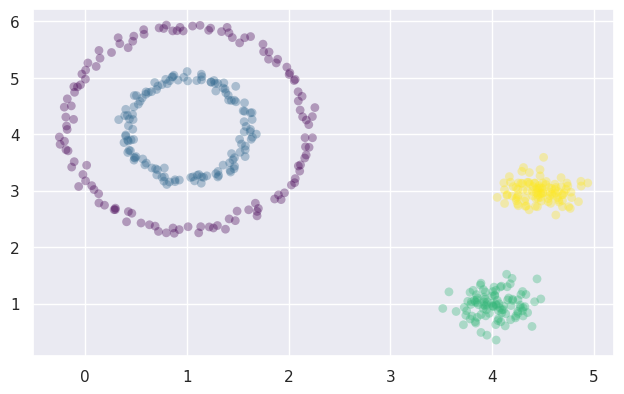

In [17]:
plt.subplots(figsize =(7.5, 4.5))
plt.scatter(df['Value_1'], df['Value_2'], c=labels,cmap='viridis', **plot_kwds)

### <span style="color:#4CC9F0">Predicción con el HDBSCAN</span>

In [18]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True).fit(datak)

In [19]:
df_new = pd.DataFrame({'Col1': [0, 1.5, 1, 4],
                   'Col2': [1.5, 1, 4, 0]})
test_points = np.array(df_new)
test_points

array([[0. , 1.5],
       [1.5, 1. ],
       [1. , 4. ],
       [4. , 0. ]])

In [20]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
test_labels

array([-1, -1, -1,  2], dtype=int32)

In [21]:
hdb2_cluster = pd.DataFrame(test_labels)  
df_new = pd.concat([df_new, hdb2_cluster], axis=1)
df_new.columns = ['Value_1', 'Value_2', 'hdb_cluster']
df_new.head()

,Value_1,Value_2,hdb_cluster
0,0.0,1.5,-1
1,1.5,1.0,-1
2,1.0,4.0,-1
3,4.0,0.0,2


In [22]:
data_frames = [df, df_new]

df_final = pd.concat(data_frames)
df_final.tail()

,Value_1,Value_2,hdb_cluster
449,4.185492,0.965273,2
0,0.000000,1.500000,-1
1,1.500000,1.000000,-1
2,1.000000,4.000000,-1
3,4.000000,0.000000,2


In [23]:
df_final['hdb_cluster'].value_counts()

 1    125
 0    125
 2    101
 3    100
-1      3
Name: hdb_cluster, dtype: int64

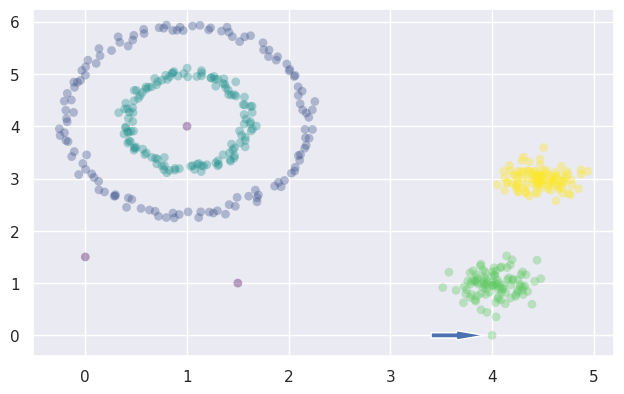

In [24]:
plt.subplots(figsize =(7.5, 4.5))
plt.scatter(df_final['Value_1'], df_final['Value_2'], c=df_final['hdb_cluster'], cmap='viridis', **plot_kwds)
plt.arrow(3.4, 0, 0.25,0, width = 0.1, head_width = 0.18)

Como se pudo ver en este ejemplo para la clasificación de nuevas observaciones, sólo una de ellas se encontraba “próxima” a uno de los clusters previamente identificados, por tanto a esta nueva observación se le asignó la etiqueta correspondiente a este último. Por otra parte los puntos restantes no se encontraban próximos a ninguno de los clusters y por lo tanto al momento de realizar la clasificación el algoritmo les asignó una nueva etiqueta, dando a entender que estos no pertenecen a alguno de los clusters. 

## <span style="color:#4361EE">Ejemplos de aplicacion  </span> 



Consideremos el conjunto de datos MNIST de sklearn, este conjunto de datos está compuesto por 70.000 imágenes de números manuscritos del 0 al 9 a una resolución de $24 \times 24$ pixeles. Dado que de este conjunto de datos conocemos las etiquetas de cada una de las observaciones, procederemos a verificar el desempeño del HDBSCAN construyendo los clusters. 

In [2]:
from sklearn.datasets import fetch_openml
import umap
import umap.plot
import hdbscan

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
y = y.astype(int)
X = X.to_numpy()

In [5]:
mapper = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X)

In [6]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(mapper)

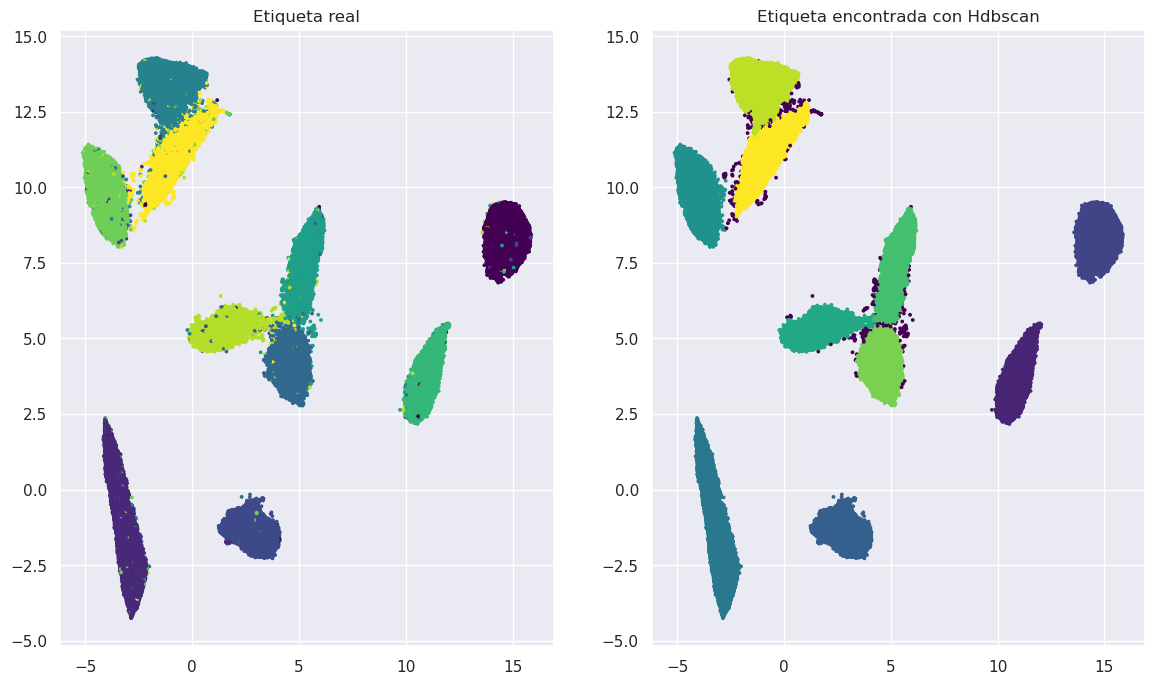

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,8))
ax1.scatter(mapper[:,0],mapper[:,1], s = 3, c = y, cmap='viridis')
ax1.set_title("Etiqueta real")
ax2.scatter(mapper[:,0],mapper[:,1], s = 3, c = labels, cmap='viridis')
ax2.set_title("Etiqueta encontrada con Hdbscan");

En la gráfica anterior podemos observar que la gran mayoría de los datos fueron agrupados correctamente mostrando el gran desempeño del HDBSCAN.

In [57]:
sin_clas = np.where(labels == -1)

In [52]:
def plot_digits(X, title):
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="viridis")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

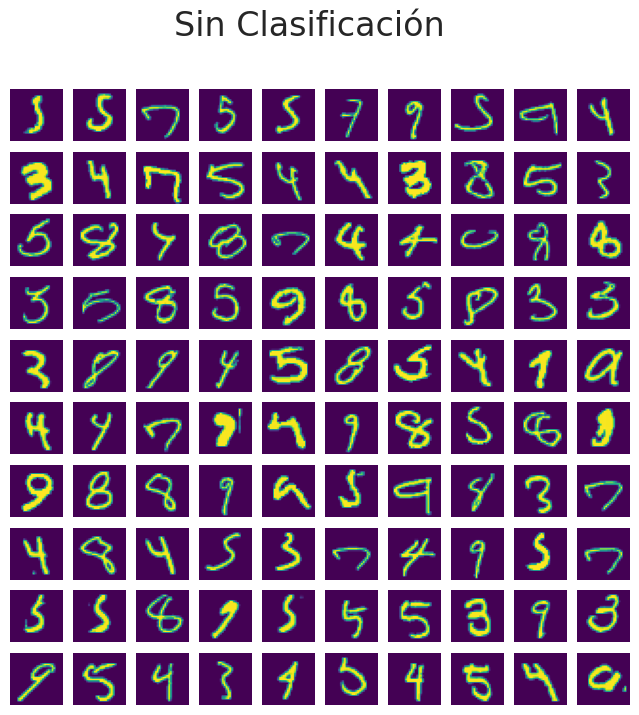

In [58]:
plot_digits(X[sin_clas], "Sin Clasificación")

En la imagen anterior mostramos algunas de las imágenes que no fueron clasificadas en alguno de los clusters hallados por el HDBSCAN.

### <span style="color:#4CC9F0">Ventajas y desventajas del HDBSCAN </span>

### Pros
- Los clusters no son obligatoriamente esféricos, pueden tomar cualquier forma y adaptarse al conjunto de datos.
- Con los hiperparámetros el modelo infiere directamente los cluster, no tenemos que pasarle el número de cluster que queremos
- Es muy bueno detectando outliers.
- El algoritmo descarta puntos que no cumplen los criterios de densidad y distancia.
- Cada cluster puede tener una densidad distinta (solo en HDBSCAN).

### Contras
- Es un modelo no determinista, la solución cambia cada vez que lo entrenemos.
- Tiene problemas al tratar con datos de muchas dimensiones. Por ejemplo en NLP no da buenos resultados, ya que suele haber miles y miles de dimensiones.
- Tiene un mal desempeño cuando la cantidad de observaciones es pequeña o los datos estan muy dispersos.

## <span style="color:#4361EE">Ejercicios para el Lector</span> 

- Como ejercicio te proponemos reproducir lo visto en este notebook con el conjunto de imágenes de  [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
- Realice una simulación de dos clusters con una alta dispersion y muestre la deficiencia del HDBSCAN en este contexto

## <span style="color:#4361EE">Referencias</span> 

1. Campello, R.J.G.B., Moulavi, D., Sander, J. (2013). Density-Based Clustering Based on Hierarchical Density Estimates. In: Pei, J., Tseng, V.S., Cao, L., Motoda, H., Xu, G. (eds) Advances in Knowledge Discovery and Data Mining. PAKDD 2013. Lecture Notes in Computer Science(), vol 7819. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-37456-2_14
2. L. McInnes and J. Healy, "Accelerated Hierarchical Density Based Clustering," 2017 IEEE International Conference on Data Mining Workshops (ICDMW), 2017, pp. 33-42, doi: 10.1109/ICDMW.2017.12.
3. Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. The elements of statistical learning: data mining, inference, and prediction. Springer Science & Business Media, 2009.
4. https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
5. https://michael-fuchs-python.netlify.app/2020/06/20/hdbscan/
6. https://github.com/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb